# Importing libraries needed

In [1]:
import pandas as pd
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier


from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report,confusion_matrix

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')

warnings.simplefilter('ignore')

data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

# Reading Data

In [2]:
print(len(data_train))
data_train.head()

7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
data_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [4]:
print(len(data_test))
data_test.head()

3263


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
data_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

# Data Preprocessing

In [6]:
#I concatenate both training and testing data to avoid doing the same operations twice plus we need it for vectorization
data_combined = pd.concat([data_train,data_test],ignore_index=True)  
print(len(data_combined))
data_combined.head()

10876


,id,keyword,location,target,text
0,1,NaN,NaN,1.0,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,1.0,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,1.0,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,1.0,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,1.0,Just got sent this photo from Ruby #Alaska as ...


In [7]:
data_combined.drop(['id','target'],axis=1,inplace=True)

In [8]:
#Total Nan Values
data_combined.isnull().sum()

keyword       87
location    3638
text           0
dtype: int64

In [9]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, remove words containing numbers and removing weird characters from tweets'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[()[\]{}\''',.``?:;!&^]','',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('#','',text)
    text = re.sub('û*','',text)
    text = re.sub('ûó*','',text)
    text = re.sub('ò*','',text)
    text = re.sub(r'[^\w]', ' ', text)
    text = re.sub('[^a-zA-Z]+', ' ', text)
    return text
round1 = lambda x: clean_text_round1(x)

In [10]:
data_clean = pd.DataFrame(data_combined.text.apply(round1))
data_clean.head()

,text
0,our deeds are the reason of this earthquake ma...
1,forest fire near la ronge sask canada
2,all residents asked to shelter in place are be...
3,people receive wildfires evacuation orders in...
4,just got sent this photo from ruby alaska as s...


## Tokenizing and removing stop words

In [11]:
stop_words = set(stopwords.words('english'))
data_clean['text_tokenized']= data_clean['text'].map(lambda x : word_tokenize(x))
data_clean.head()

,text,text_tokenized
0,our deeds are the reason of this earthquake ma...,"[our, deeds, are, the, reason, of, this, earth..."
1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,all residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place..."
3,people receive wildfires evacuation orders in...,"[people, receive, wildfires, evacuation, order..."
4,just got sent this photo from ruby alaska as s...,"[just, got, sent, this, photo, from, ruby, ala..."


In [12]:
def removing_stop_words(text_tokenized) :
    text_tokenized = [w for w in text_tokenized if w not in stop_words]
    for w in text_tokenized :
        w = w.strip()
    return text_tokenized

In [13]:
data_clean['text_tokenized']= data_clean['text_tokenized'].map(lambda x : removing_stop_words(x))
data_clean.head()

,text,text_tokenized
0,our deeds are the reason of this earthquake ma...,"[deeds, reason, earthquake, may, allah, forgiv..."
1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,all residents asked to shelter in place are be...,"[residents, asked, shelter, place, notified, o..."
3,people receive wildfires evacuation orders in...,"[people, receive, wildfires, evacuation, order..."
4,just got sent this photo from ruby alaska as s...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


# Slangs Fix

In [14]:
#special thanks to this kernel for the amazing slang fix :
#https://www.kaggle.com/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing

abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "after midday",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [ ]:
def convert_abbrev(text):
    for word in text : 
        a = word
        word = abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word
        l = word.split(' ')
        text = text + l
        text.remove(a)
    return text
data_clean['text_tokenized']=data_clean['text_tokenized'].map(lambda x: convert_abbrev(x))
data_clean.head()

## Using Word clouds to figure out most frequent words in Tweets that are real or not

In [15]:
words_cloud_data=data_clean.copy()
words_cloud_data["word_cloud_text"]=words_cloud_data["text_tokenized"].map(lambda x : ' '.join(x))
words_cloud_data = words_cloud_data[0:7612]
words_cloud_data['target']=data_train['target']
words_cloud_data.drop(['text','text_tokenized'],axis=1,inplace=True)

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

plt.rcParams['figure.figsize'] = [16, 6]

target_1 =""
target_0 =""

for i in range(len(words_cloud_data)) :
    if words_cloud_data["target"][i]== 1 :
        target_1 = target_1 + words_cloud_data["word_cloud_text"][i]+" "
    if words_cloud_data["target"][i] == 0 :
        target_0 = target_0 + words_cloud_data["word_cloud_text"][i]+ " "


wc.generate(target_1)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<Figure size 1600x600 with 1 Axes>

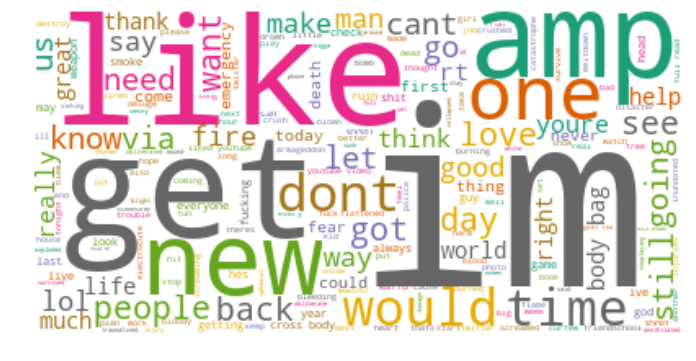

In [17]:
plt.rcParams['figure.figsize'] = [16, 6]
wc.generate(target_0)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [18]:
#Some words are very frequent in both target classes, removing them would improve model's score
def remove_confusing_words(text) :
    for i in text :
        if i == 'amp' or i == 'new' or i=='people' :
            text.remove(i)
    return text
data_clean['text_tokenized']=data_clean['text_tokenized'].map(lambda x: remove_confusing_words(x))
data_clean.head()

,text,text_tokenized
0,our deeds are the reason of this earthquake ma...,"[deeds, reason, earthquake, may, allah, forgiv..."
1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,all residents asked to shelter in place are be...,"[residents, asked, shelter, place, notified, o..."
3,people receive wildfires evacuation orders in...,"[receive, wildfires, evacuation, orders, calif..."
4,just got sent this photo from ruby alaska as s...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


# Dealing with missing locations and keywords

In [19]:
data_clean['location']=data_combined['location']
data_clean['keyword']=data_combined['keyword']
data_clean.head()

,text,text_tokenized,location,keyword
0,our deeds are the reason of this earthquake ma...,"[deeds, reason, earthquake, may, allah, forgiv...",NaN,NaN
1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",NaN,NaN
2,all residents asked to shelter in place are be...,"[residents, asked, shelter, place, notified, o...",NaN,NaN
3,people receive wildfires evacuation orders in...,"[receive, wildfires, evacuation, orders, calif...",NaN,NaN
4,just got sent this photo from ruby alaska as s...,"[got, sent, photo, ruby, alaska, smoke, wildfi...",NaN,NaN


In [20]:
#dataset containing a good number of cities and their countries that will be usefull for us
cities_data = pd.read_csv('worldcities.csv')

In [21]:
cities_data.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [22]:
cities_data.drop(['city','lat','lng','admin_name','capital','population','id','iso2','iso3'],axis=1,inplace=True)

In [23]:
cities_data.head()

,city_ascii,country
0,Tokyo,Japan
1,New York,United States
2,Mexico City,Mexico
3,Mumbai,India
4,Sao Paulo,Brazil


In [24]:
cities_dict = {}

for i in range(len(cities_data)) :
    if cities_data['country'][i] in cities_dict :
        cities_dict[cities_data['country'][i]].append(cities_data['city_ascii'][i].lower())
    else :
        cities_dict[cities_data['country'][i]] = list()
        cities_dict[cities_data['country'][i]].append(cities_data['city_ascii'][i].lower())

In [25]:
cities_to_countries = {}
for i,j in cities_dict.items() :
    for element in j :
        cities_to_countries[element]=i.lower()          

In [26]:
countries_names = list(cities_dict.keys())
countries_names_min = [] 
for i in countries_names :
    countries_names_min.append(i.lower())        

In [27]:
cities  = [] 
for j in cities_dict.values() : 
    cities = cities + j   

In [28]:
keywords=list(data_clean['keyword'].value_counts().index) # creating a list of existing keywords
locations=list(data_clean['location'].value_counts().index) #creating a list of existing locations
countries_names_min = countries_names_min+locations #adding existing locations to the ones from the dataset

# Adding 2 features: whether location or keyword exist or not 

In [29]:
def isNaN(num):
    return num != num

In [ ]:
data_clean['Location_not_Nan']=0
data_clean['Keyword_not_Nan']=0

In [ ]:
for i in range(len(data_clean)) :
    if isNaN(data_clean['location'][i]) :
        data_clean['Location_not_Nan'][i]=0
    else :
        data_clean['Location_not_Nan'][i]=1
    if isNaN(data_clean['keyword'][i]) :
        data_clean['Keyword_not_Nan'][i]=0
    else :
        data_clean['Keyword_not_Nan'][i]=1

In [30]:
data_clean.head()

,text,text_tokenized,location,keyword
0,our deeds are the reason of this earthquake ma...,"[deeds, reason, earthquake, may, allah, forgiv...",NaN,NaN
1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",NaN,NaN
2,all residents asked to shelter in place are be...,"[residents, asked, shelter, place, notified, o...",NaN,NaN
3,people receive wildfires evacuation orders in...,"[receive, wildfires, evacuation, orders, calif...",NaN,NaN
4,just got sent this photo from ruby alaska as s...,"[got, sent, photo, ruby, alaska, smoke, wildfi...",NaN,NaN


In [31]:
for i in range(len(data_clean)):
    if isNaN(data_clean['location'][i]) :
        for j in data_clean['text_tokenized'][i] :
            if j in countries_names_min :
                data_clean['location'][i]=j
            elif j in cities :
                data_clean['location'][i]=cities_to_countries[j]
            else :
                data_clean['location'][i]="NoLocation"
            if j in keywords :
                data_clean['keyword'][i] = j

After all attempts location and keywords still have missing values I decided to fill them with mode

In [32]:
data_clean['location'].fillna(data_clean['location'].mode()[0],inplace=True)

In [33]:
data_clean['location']=data_clean['location'].map(lambda x : x.lower())

In [34]:
data_clean['keyword'].fillna(data_clean['keyword'].mode()[0],inplace=True)

Removing redundant categories from both keyword and location

In [35]:
def changing_location(text) :
    if text == 'usa' or text == 'new york' or text == 'gainesville/tampa, fl' or text =='glendale, ca' or text == 'harbour heights, fl' or text =='new jersey' :
        text = 'united states'
    elif text == 'london' or text == 'brentwood uk' :
        text = 'uk'
    return text

def changing_keyword(text) :
    text = re.sub('^.*fire.*$','fire',text)
    text = re.sub('^.*storm.*$','storm',text)
    text = re.sub('^.*emergency.*$','emergency',text)
    text = re.sub('^.*disaster.*$','disaster',text)
    text = re.sub('^.*collapse.*$','collapse',text)
    text = re.sub('^.*bombing.*$','bombing',text)
    text = re.sub('^.*bomb.*$','bomb',text)
    text = re.sub('^.*zone.*$','zone',text)
    text = re.sub('^.*bagging.*$','bagging',text)

    return text


In [36]:
data_clean['location']=data_clean['location'].map(lambda x : changing_location(x))
data_clean['keyword']=data_clean['keyword'].map(lambda x: changing_keyword(x))

In [37]:
frequency_map_location = data_clean['location'].value_counts().to_dict()
frequency_map_keyword = data_clean['keyword'].value_counts().to_dict()

In [38]:
data_clean['location'] = data_clean['location'].map(frequency_map_location)
data_clean['keyword'] = data_clean['keyword'].map(frequency_map_keyword)
data_clean.head()

,text,text_tokenized,location,keyword
0,our deeds are the reason of this earthquake ma...,"[deeds, reason, earthquake, may, allah, forgiv...",19,60
1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",50,482
2,all residents asked to shelter in place are be...,"[residents, asked, shelter, place, notified, o...",3458,54
3,people receive wildfires evacuation orders in...,"[receive, wildfires, evacuation, orders, calif...",31,54
4,just got sent this photo from ruby alaska as s...,"[got, sent, photo, ruby, alaska, smoke, wildfi...",3458,55


# Stemming

In [39]:
#I chose lancaster stemmer because it's the heaviest stemmer between porter stemmer and snowballstemmer
from nltk.stem import LancasterStemmer
lancaster = LancasterStemmer()

In [40]:
def lancaster_stemming(text_tokenized) :
    text_tokenized = [lancaster.stem(w) for w in text_tokenized]
    return ' '.join(text_tokenized)

In [41]:
data_clean['text_tokenized']=data_clean['text_tokenized'].map(lambda x:lancaster_stemming(x))
data_clean.head()

,text,text_tokenized,location,keyword
0,our deeds are the reason of this earthquake ma...,dee reason earthquak may allah forg us,19,60
1,forest fire near la ronge sask canada,forest fir near la rong sask canad,50,482
2,all residents asked to shelter in place are be...,resid ask shelt plac not off evacu shelt plac ...,3458,54
3,people receive wildfires evacuation orders in...,receiv wildfir evacu ord californ,31,54
4,just got sent this photo from ruby alaska as s...,got sent photo ruby alask smok wildfir pour sc...,3458,55


# Adding 3 features Number of words in the tweet, number of unique words in the tweet and average word length

In [42]:
def words_in_tweet(text) :
    l = text.split(' ')
    return len(l)
data_clean['tweet_length']=data_clean['text_tokenized'].map(lambda x: words_in_tweet(x))

In [43]:
def avg_length(text) :
    l = text.split(' ')
    len1 = 0
    for i in l :
        len1 += len(i)
    return len1 / len(l) 
data_clean['avg_word_length'] = data_clean['text_tokenized'].map(lambda x:avg_length(x))

In [44]:
data_clean['unique_words']=data_clean['text_tokenized'].map(lambda x:len(set(x.split(' '))))

In [45]:
data_clean.head()

,text,text_tokenized,location,keyword,tweet_length,avg_word_length,unique_words
0,our deeds are the reason of this earthquake ma...,dee reason earthquak may allah forg us,19,60,7,4.571429,7
1,forest fire near la ronge sask canada,forest fir near la rong sask canad,50,482,7,4.000000,7
2,all residents asked to shelter in place are be...,resid ask shelt plac not off evacu shelt plac ...,3458,54,11,4.181818,9
3,people receive wildfires evacuation orders in...,receiv wildfir evacu ord californ,31,54,5,5.800000,5
4,just got sent this photo from ruby alaska as s...,got sent photo ruby alask smok wildfir pour sc...,3458,55,9,4.666667,9


# Target Encoding some features

In [46]:
data_clean_train1 = data_clean[0:7613]
data_clean_test1 = data_clean[7613:]

In [47]:
data_clean_train1['prediction_target']=data_train['target']

In [48]:
features_to_encode = ['keyword','location','tweet_length','unique_words']

for col in features_to_encode :
    means = data_clean_train1.groupby(col)['prediction_target'].mean()
    data_clean_train1[col] = data_clean_train1[col].map(means)
    data_clean_test1[col] = data_clean_test1[col].map(means)   

In [49]:
data_clean_test1.isnull().sum()

text               0
text_tokenized     0
location           0
keyword            0
tweet_length       2
avg_word_length    0
unique_words       0
dtype: int64

In [50]:
data_clean_test1['tweet_length'].fillna(data_clean_test1['tweet_length'].mean(),inplace=True)

# TF-IDF Words and Chars

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),
    norm='l2',
    min_df=0,
    smooth_idf=False,
    max_features=15000)
features = word_vectorizer.fit(data_clean['text_tokenized'])
train_word_features = word_vectorizer.transform(data_clean_train1['text_tokenized'])
data_tfidf_train_word = pd.DataFrame(train_word_features.toarray(),columns=word_vectorizer.get_feature_names())
test_word_features = word_vectorizer.transform(data_clean_test1['text_tokenized'])
data_tfidf_test_word = pd.DataFrame(test_word_features.toarray(),columns=word_vectorizer.get_feature_names())

In [52]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    norm='l2',
    min_df=0,
    smooth_idf=False,
    max_features=30000)
char_features=char_vectorizer.fit(data_clean['text_tokenized'])
train_char_features = char_vectorizer.transform(data_clean_train1['text_tokenized'])
data_tfidf_train_char = pd.DataFrame(train_char_features.toarray(),columns=char_vectorizer.get_feature_names())
test_char_features = char_vectorizer.transform(data_clean_test1['text_tokenized'])
data_tfidf_test_char = pd.DataFrame(test_char_features.toarray(),columns=char_vectorizer.get_feature_names())

In [53]:
'''from scipy.sparse import hstack

train_features = hstack([train_char_features, train_word_features]).tocsr()
test_features = hstack([test_char_features, test_word_features]).tocsr()'''

'from scipy.sparse import hstack\n\ntrain_features = hstack([train_char_features, train_word_features]).tocsr()\ntest_features = hstack([test_char_features, test_word_features]).tocsr()'

In [54]:
data_clean_train1.drop(['text','text_tokenized'],axis=1,inplace=True)
data_clean_test1.drop(['text','text_tokenized'],axis=1,inplace=True)

In [55]:
data_clean_train1 = pd.concat([data_clean_train1,data_tfidf_train_char,data_tfidf_train_word],axis=1)
data_clean_test1 = pd.concat([data_clean_test1,data_tfidf_test_char,data_tfidf_test_word],axis=1)

In [56]:
data_clean_test1.shape

(6526, 45005)

# Count Vectorizer

In [ ]:
def count_vect(data_clean):
    cv = CountVectorizer(stop_words='english')
    data_cv = cv.fit_transform(data_clean.text_tokenized)
    data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    data_dtm.index = data_clean.index
    return data_dtm

data_vectorized = count_vect(data_clean[['text_tokenized']])
data_vectorized.head() 

In [ ]:
data_clean1 = pd.concat([data_clean,data_vectorized],axis=1)

In [ ]:
data_clean1.shape

In [ ]:
data_clean_train1.drop(['text','text_tokenized'],axis=1,inplace=True)
data_clean_test1.drop(['text','text_tokenized'],axis=1,inplace=True)

# Modeling

In [ ]:
y= data_clean_train1['prediction_target']
X= data_clean_train1.drop(['prediction_target','location','keyword'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=30)

In [ ]:
data_clean_test1 = data_clean_test1.drop(['location','keyword'],axis=1)

In [ ]:
import numpy as np
def select_model(x,y,model):
    scores=cross_val_score(model,x,y,cv=5,scoring='f1')
    acc=np.mean(scores)
    return acc

In [ ]:
gaus_NB = GaussianNB()
print(select_model(X,y,gaus_NB))

In [ ]:
random_cv = RandomizedSearchCV(estimator = model ,
                               param_distributions = parameters,
                               cv = 5,n_iter=50,scoring=f1,verbose=5,return_train_score=True)
random_cv.fit(X,y)
random_cv.best_estimator_

In [ ]:
multi_NB = MultinomialNB()
print(select_model(X,y,multi_NB))

In [ ]:
multi_NB.fit(X,y)
predictions = multi_NB.predict(data_clean_test1)

In [ ]:
nb_pred = pd.DataFrame(predictions,columns=['target'])
nb_pred.insert(0,'id',data_test['id'])
nb_pred.to_csv("MysubmissionNB.csv",index=False)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print('Accuracy = {:.2f}'.format(logreg.score(X_test, y_test)))

In [ ]:
mlp = MLPClassifier()
mlp = mlp.fit(X_train,y_train)
mlp_pred = mlp.predict(X_test)
print(classification_report(y_test, mlp_pred))
print('Accuracy = {:.2f}'.format(mlp.score(X_test, y_test)))

In [ ]:
rfc = RandomForestClassifier()
rfc = rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test, rfc_pred))

In [ ]:
parameters = {
  'n_estimators' : [50,100,200,300,400],
    'max_depth' : [1,3,5,7,9]
}
random_cv = RandomizedSearchCV(estimator = rfc ,
                               param_distributions = parameters,
                               cv = 5,n_iter=100,scoring=f1,verbose=5,return_train_score=True)
random_cv.fit(X,y)
random_cv.best_estimator_

In [ ]:
ada = AdaBoostClassifier()
ada = ada.fit(X_train,y_train)
ada_pred = ada.predict(X_test)
print(classification_report(y_test, ada_pred))

In [ ]:
gbc = GradientBoostingClassifier()
gbc= gbc.fit(X_train,y_train)
gbc_pred = gbc.predict(X_test)
print(classification_report(y_test, gbc_pred))

In [ ]:
etc = ExtraTreesClassifier()
etc = etc.fit(X_train,y_train)
etc_pred = etc.predict(X_test)
print(classification_report(y_test, etc_pred))

# Stacking

In [ ]:
estimators = [
   ('rf', rfc),
    ('mlp', make_pipeline(StandardScaler(),
                       mlp  )),
    ('multi_nb',multi_NB),
    ('ada',ada),
    ('etc',etc)
 ]

In [ ]:
clf = StackingClassifier(
    estimators=estimators, final_estimator=logreg)
clf.fit(X,y)
predictions = clf.predict(data_clean_test1)

In [ ]:
stacking_pred = pd.DataFrame(predictions,columns=['target'])
stacking_pred.insert(0,'id',data_test['id'])
stacking_pred.to_csv("MysubmissionStack.csv",index=False)
#0.8036

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

model = XGBClassifier()

parameters = {
    'n_estimators' : [600],
    'learning_rate' : [0.4],
    'max_depth' : [6],
    'booster' : ['gbtree'],
    'n_jobs' : [-1],
    'objective' : ['binary:logistic']
}

In [ ]:
random_cv = RandomizedSearchCV(estimator = model ,
                               param_distributions = parameters,
                               cv = 5,n_iter=50,scoring=f1,verbose=5,return_train_score=True)

In [ ]:
random_cv.fit(X,y)

In [ ]:
random_cv.best_estimator_

In [ ]:
predictions = random_cv.predict(data_clean_test1)

In [ ]:
xgbpred = pd.DataFrame(predictions,columns=['target'])
xgbpred.insert(0,'id',data_test['id'])
xgbpred.to_csv("MysubmissionXGB.csv",index=False)

In [ ]:
model = CatBoostClassifier()
print(select_model(X,y,model))

In [ ]:
model = LGBMClassifier(n_estimators=300)
print(select_model(X,y,model))

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils
import tensorflow as tf

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras import regularizers

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=(15754),
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=10**-8, decay=0.0001, amsgrad=False)
model.compile(optimizer= adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
print(model.summary())

In [ ]:
hist = model.fit(X, y,
                    batch_size=16,
                    epochs=20,
                    verbose=1)

In [ ]:
%matplotlib inline

history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12))
plt.plot(history["loss"],label='Train Loss')
plt.plot(history["val_loss"],label='Validation Loss')
plt.title("Loss as function of epoch");
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
predictions_val = model.predict(data_clean_test1)
predictions_val = np.where(predictions_val>0.5, 1, 0)

In [ ]:
df_predictions = pd.DataFrame(predictions_val,columns=['target'])
df_predictions.insert(0,'id',data_test['id'])
df_predictions.to_csv("MysubmissionDNN.csv",index=False)

# Summary

During this competition i learned a lot, i've tried to do my best to get the best f1-score i can get. I've tried several other things that are not in this notebook such as TF-IDF sadly it didn't improve model's score i've also had trouble with computational power despite using google colab's GPU for that i applied PCA for dimentionality reduction.

I've tried many models as well such as ADAboostClassifier, MLPClassifier, RandomForestClassifier , CatBoost and LightGBM
i still need a lot of computational power to fine tune them even though RandomizedSearch was more helpful than GridSearch

Features such as no location and no keyword which indicate whether the location or keyword existed didn't improve the models

Features such as tweet length, unique words and average word length that improved the score.

=> next up i'll try to use BERT or AutoML
Leave your comments below and let me know what you think !

Finally i would like to thank many existing notebooks that have helped me a lot specially with the DNN architecture since i'm still a beginner any advice or question is welcomed !